In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import math
import numpy as np
import hdbscan
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import mdtraj as md
from mastermsm.trajectory import traj

In [6]:
trajs = traj.MultiTimeSeries(top='send-david/data/alaTB.gro', \
                    trajs=['send-david/data/out/4_1.xtc', \
                           'send-david/data/out/protein_only.xtc'])
                           #'send-david/data/out/4_2.xtc'])

In [7]:
def dPCA(angles, t):
    """
    Compute PCA of dihedral angles

    We follow the methods described in A. Altis et al. 
    *J. Chem. Phys.*  244111 (2007)

    Parameters
    ----------
    angles :
    
    t : 
    
    Returns
    -------
    
    """
    shape = np.shape(angles)
    print (shape)
    X = np.zeros((shape[0] , \
                  shape[1]+shape[1]))
    for i, ang in enumerate(angles):
        p = 0
        for phi in ang:
            X[i][p], X[i][p+1] = np.cos(phi), np.sin(phi)
            p += 2
    X_std = StandardScaler().fit_transform(X)
    sklearn_pca = PCA(n_components=2*shape[1])
    
    X_transf = sklearn_pca.fit_transform(X_std)
    expl = sklearn_pca.explained_variance_ratio_
    
    print("Ratio of variance retrieved by each component:", expl)
    #graficamos el acumulado de varianza explicada en las nuevas dimensiones
    #plt.figure()
    #plt.plot(np.cumsum(sklearn_pca.explained_variance_ratio_))
    #plt.xlabel('number of components')
    #plt.ylabel('cumulative explained variance')
    #plt.savefig('cum_variance_%g.png'%t)

    #colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', \
    #'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'lightgray']
    #vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
    #counts, ybins, xbins, image = plt.hist2d(X_transf[:,0], X_transf[:,1], \
                #bins=[np.linspace(-np.pi,np.pi,20), np.linspace(-np.pi,np.pi,30)], \
    #            bins=20, cmap='binary_r', alpha=0.2)
    #plt.contour(np.transpose(counts), extent=[xbins.min(), xbins.max(), \
    #            ybins.min(), ybins.max()], linewidths=1, colors='gray')
    #countmax = np.amax(counts)
    #counts = np.log(countmax) - np.log(counts)
    #plt.scatter(X_transf[:,0],X_transf[:,1], c=counts)
    #plt.savefig('dpca_%g.png'%t)

    return X_transf

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mastermsm.trajectory import traj_lib

phi_cum = []
psi_cum = []
for t, tr in enumerate(trajs.traj_list):
    phi = md.compute_phi(tr.mdt)
    psi = md.compute_psi(tr.mdt)
    phi_cum.append(phi[1])
    psi_cum.append(psi[1])
phi_cum = np.vstack(phi_cum)
psi_cum = np.vstack(psi_cum)
angles = np.column_stack((phi_cum, psi_cum))

v = dPCA(angles, t)
v.shape

(10504, 2)
Ratio of variance retrieved by each component: [0.45422684 0.34040386 0.10646118 0.09890812]


(10504, 4)

n_micro_clusters: 3


<function matplotlib.pyplot.show(close=None, block=None)>

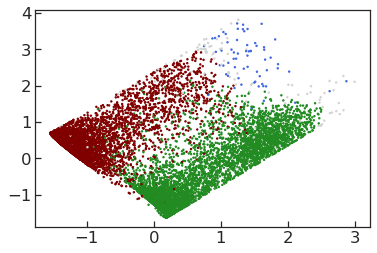

In [11]:
X = StandardScaler().fit_transform(v)
#X = v
hb = hdbscan.HDBSCAN(min_cluster_size = 55, min_samples=51).fit(X)
n_micro_clusters = len(set(hb.labels_)) - (1 if -1 in hb.labels_ else 0)
print("n_micro_clusters:",n_micro_clusters)
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', \
'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'lightgray']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
plt.scatter(X[:,0],X[:,1], c=vectorizer(hb.labels_), s=2)
plt.show

<AxesSubplot:ylabel='$\\lambda$ value'>

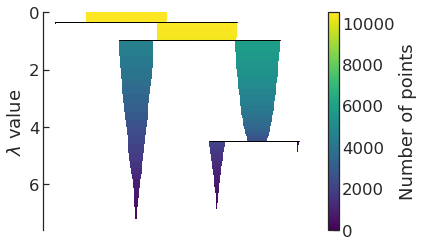

In [12]:
hb.condensed_tree_.plot()

### NOW USE THIS LABELING TO IDENTIFY CLUSTERS ON RAMACHANDRAN PLOT:

<function matplotlib.pyplot.show(close=None, block=None)>

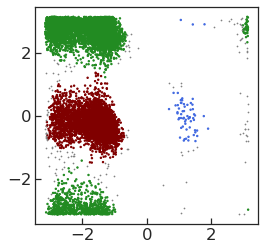

In [13]:
fig, ax = plt.subplots(figsize=(4,4))
assign = hb.labels_>=0.0
plt.scatter(phi_cum[assign],psi_cum[assign], s=2, c=vectorizer(hb.labels_[assign]))
noise = hb.labels_<0
plt.scatter(phi_cum[noise],psi_cum[noise], c='gray', s=0.5)
plt.show